In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt, matplotlib.dates as mdates

In [2]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [3]:
!pip install factor_analyzer  
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#%cd drive/MyDrive/Github/master_thesis
%cd drive/MyDrive/GitHub/master-thesis
from clustering.utils import *

/content/drive/MyDrive/GitHub/master-thesis


In [6]:
def cronbach_alpha(df):
    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

# Preprocessing

In [7]:
beh_cols = get_behaviour_cols()
df_fa_input = get_preprocessed_data(impute=True, impute_cols=beh_cols)

In [8]:
# Train Test Split
start_train = '2020-08-01'
end_train = '2020-12-01'
df_fa_input_train = df_fa_input[(df_fa_input.date >= start_train) & (df_fa_input.date < end_train)]
min(df_fa_input_train.date)

Timestamp('2020-08-01 00:00:00')

In [9]:
df_fa_input_train.shape

(33165, 80)

In [10]:
scaler = MinMaxScaler()
fa_input_train = scaler.fit_transform(df_fa_input_train[beh_cols].to_numpy())
fa_input = scaler.fit_transform(df_fa_input[beh_cols].to_numpy())
df_fa_input_scaled = pd.DataFrame(data=fa_input, columns=beh_cols)
fa_input.shape

(114107, 30)

In [11]:
df_fa_input_scaled.shape

(114107, 30)

# Voraussetzungen prüfen
ref: Klaus Backhaus et al. Multivariate analysemethoden. Springer, 2021, pp. 413–488

First, Bartlett’s test (test for sphericity) tests the null hypothesis that the sample originates from
a population in which the variables are uncorrelated. Accordingly, the alternative hypothesis shows
that the variables are correlated. This must be shown for a factor analysis to be appropriate.

In [12]:
# P Value should be smaller 0.05
statistic, p_value = calculate_bartlett_sphericity(fa_input_train)
print(statistic, p_value)

303479.2790050889 0.0


In [13]:
p_value

0.0

Second, the Kaiser-Meyer-Olkin (KMO) criterion, considers the bivariate partial correlations between all variables. This correlation describes the degree of dependence between two variables after excluding the influences of all other variables. The ideal value for a factor analysis is close to 1. In practice, values greater than 0.5 are considered sufficient; values greater than 0.8 are recommended.

In [14]:
#KMO should be greater or equal to 0.5
kmo_per_item, kmo_total = calculate_kmo(fa_input_train)
kmo_total

/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.8984113797780171

In contrast, the Measure of Sampling Adequacy (MSA) as a third method assesses the suitability of individual variables for a factor analysis. This can also be determined with the help of the KMO. If individual variables have MSA values below 0.5, they can be excluded from the factor analysis.

In [15]:
kmo_per_item

array([0.81017432, 0.9041821 , 0.89409625, 0.85195593, 0.92098223,
       0.88213049, 0.68340175, 0.76079546, 0.91568771, 0.9349295 ,
       0.92840167, 0.95501478, 0.93251228, 0.92538465, 0.90610969,
       0.92035496, 0.77000412, 0.76532974, 0.70044442, 0.9351887 ,
       0.7969391 , 0.77266983, 0.92862454, 0.87716942, 0.94050666,
       0.94106738, 0.93803211, 0.73994611, 0.92996888, 0.92323957])

In [16]:
(kmo_per_item < 0.5).sum()

0

The fourth and last criterion is the anti-image covariance matrix. The anti-image represents the proportion of the variance that is independent of the other variables. Since factor analysis assumes that common factors are the basis of the variables, the variables are only suitable if they have a high common variance. Accordingly, the anti-image of the variables should be close to zero. As a rule of thumb, the data is suitable if less than 25\% of the non-diagonal elements of the matrix are different from zero.

In [17]:
# calc anti-image covariance matrix
R = np.corrcoef(fa_input_train, rowvar=False)
R_inv = np.linalg.inv(R)
temp = np.diagflat(R_inv.diagonal())
D = np.linalg.inv(temp)

In [18]:
anti_image_covariance_matrix = np.dot(np.dot(D, R_inv), D)

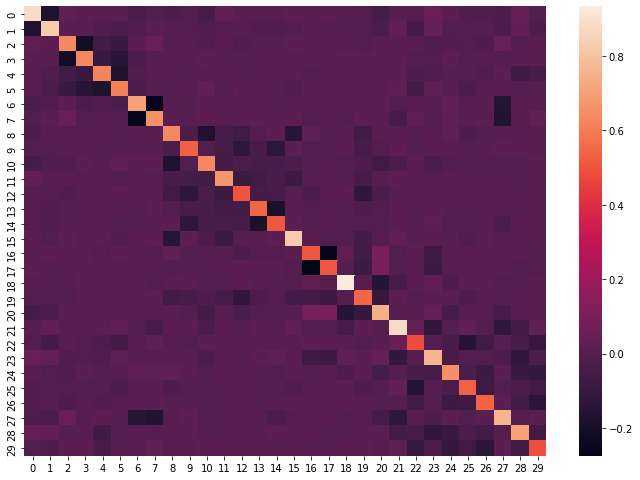

In [19]:
sns.heatmap(anti_image_covariance_matrix)

In [20]:
diff_zero_value = 0.03
num_non_diag_values_differ_from_zero = (anti_image_covariance_matrix > diff_zero_value).sum() + (anti_image_covariance_matrix < -diff_zero_value).sum() - anti_image_covariance_matrix.shape[0]
num_non_diag_values = anti_image_covariance_matrix.shape[0]**2 - - anti_image_covariance_matrix.shape[0]
percentage = num_non_diag_values_differ_from_zero / num_non_diag_values * 100
percentage

21.0752688172043

# Factor Analysis

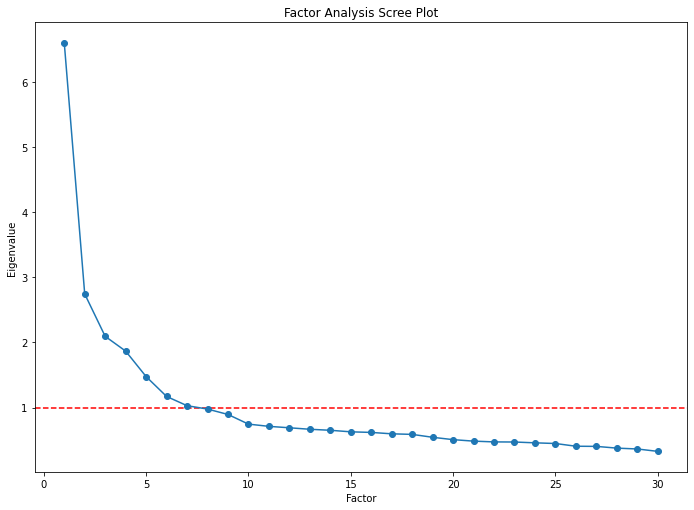

In [21]:
fa = FactorAnalyzer(rotation=None)
fa.fit(fa_input_train)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
plt.title('Factor Analysis Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='dashed')
plt.plot(range(1,fa_input_train.shape[1]+1),ev, marker='o')
plt.savefig('images/scree_plot_factor_analysis.png')

In [22]:
ev

array([6.5997194 , 2.7431722 , 2.09257259, 1.86611711, 1.47483435,
       1.17012182, 1.02828919, 0.9764165 , 0.89369921, 0.74550875,
       0.71116801, 0.68913762, 0.66641806, 0.65084944, 0.62717432,
       0.61804683, 0.59657928, 0.58790404, 0.54321118, 0.50710748,
       0.48446659, 0.47243503, 0.47078791, 0.45826891, 0.44787198,
       0.40604662, 0.40377827, 0.37704054, 0.36397276, 0.327284  ])

In [23]:
num_factors_one = (ev > 1).sum()
num_factors_avg = (ev > ev.mean()).sum()
explained_variance = ev[:num_factors_one].sum() / ev.sum()
print(f'Es gibt {num_factors_one} Eigenwerte, die größer als eins sind und {num_factors_avg} Eigenwerte, die größer als der Durchschnitt sind. Damit werden {round(explained_variance * 100, 3)} % der Varianz erklärt.')

Es gibt 7 Eigenwerte, die größer als eins sind und 7 Eigenwerte, die größer als der Durchschnitt sind. Damit werden 56.583 % der Varianz erklärt.


In [24]:
n_factor = 5
fa = FactorAnalyzer(n_factor, rotation='varimax')
fa.fit(fa_input_train)
loads = fa.loadings_

# Evaluate Factors

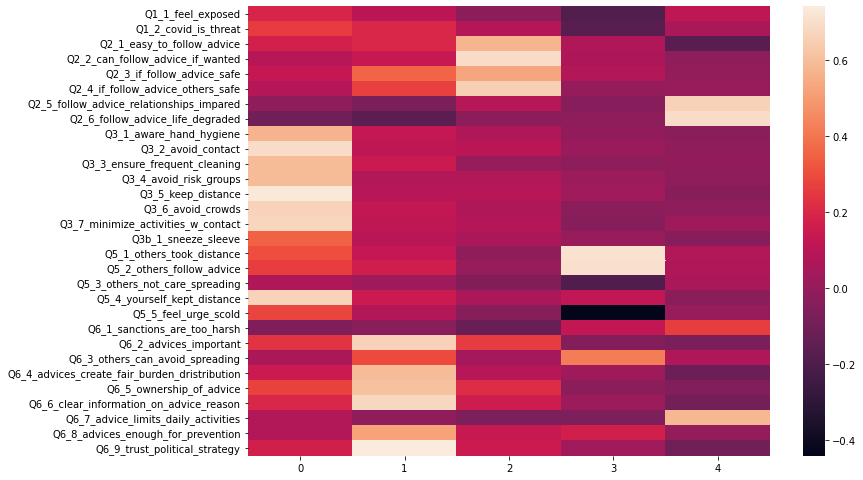

In [25]:
heatmap_data = pd.DataFrame(loads.T, columns=beh_cols).T
heatmap_loadings = sns.heatmap(heatmap_data)
fig = heatmap_loadings.get_figure()
fig.savefig("images/heatmap_factor_loadings.png")

In [26]:
heatmap_data

,0,1,2,3,4
Q1_1_feel_exposed,0.193451,0.102915,-0.023424,-0.188906,0.115075
Q1_2_covid_is_threat,0.260386,0.201320,0.082183,-0.171920,0.054302
Q2_1_easy_to_follow_advice,0.174471,0.203311,0.575262,0.072550,-0.166638
Q2_2_can_follow_advice_if_wanted,0.093521,0.140422,0.694559,0.063267,-0.017650
Q2_3_if_follow_advice_safe,0.133210,0.355447,0.533762,0.080647,-0.002759
Q2_4_if_follow_advice_others_safe,0.087885,0.268932,0.649485,0.001332,0.011855
Q2_5_follow_advice_relationships_impared,-0.012384,-0.070138,0.090959,-0.036721,0.662241
Q2_6_follow_advice_life_degraded,-0.098596,-0.154304,-0.027489,-0.018210,0.694653
Q3_1_aware_hand_hygiene,0.568595,0.128853,0.071753,-0.008854,-0.033646
Q3_2_avoid_contact,0.691886,0.116064,0.100853,0.016379,-0.015066


In [27]:
dict_fa = {}
for i in np.arange(n_factor):
  col_names = heatmap_data[heatmap_data[i].abs() >= 0.5][i].index.tolist()
  df_factor = df_fa_input_scaled[col_names]
  factor_alpha = cronbach_alpha(df_factor)
  temp_dict = {'Factor_Names': col_names, 'Data': df_factor, 'Cronbach_Alpha': factor_alpha}
  print(f'Factor {i} with Columns {col_names} has a Cronbachs Alpha of {factor_alpha}')
  dict_fa.update({i: temp_dict})

Factor 0 with Columns ['Q3_1_aware_hand_hygiene', 'Q3_2_avoid_contact', 'Q3_3_ensure_frequent_cleaning', 'Q3_4_avoid_risk_groups', 'Q3_5_keep_distance', 'Q3_6_avoid_crowds', 'Q3_7_minimize_activities_w_contact', 'Q5_4_yourself_kept_distance'] has a Cronbachs Alpha of 0.8806753029501455
Factor 1 with Columns ['Q6_2_advices_important', 'Q6_4_advices_create_fair_burden_dristribution', 'Q6_5_ownership_of_advice', 'Q6_6_clear_information_on_advice_reason', 'Q6_8_advices_enough_for_prevention', 'Q6_9_trust_political_strategy'] has a Cronbachs Alpha of 0.8485088475119451
Factor 2 with Columns ['Q2_1_easy_to_follow_advice', 'Q2_2_can_follow_advice_if_wanted', 'Q2_3_if_follow_advice_safe', 'Q2_4_if_follow_advice_others_safe'] has a Cronbachs Alpha of 0.7833034833929209
Factor 3 with Columns ['Q5_1_others_took_distance', 'Q5_2_others_follow_advice'] has a Cronbachs Alpha of 0.8092804407123634
Factor 4 with Columns ['Q2_5_follow_advice_relationships_impared', 'Q2_6_follow_advice_life_degraded', '

In [28]:
col_names = ['Q1_1_feel_exposed', 'Q1_2_covid_is_threat', 'Q6_1_sanctions_are_too_harsh', 'Q6_3_others_can_avoid_spreading']
df_fa_input_scaled[col_names].describe()

,Q1_1_feel_exposed,Q1_2_covid_is_threat,Q6_1_sanctions_are_too_harsh,Q6_3_others_can_avoid_spreading
count,114107.000000,114107.000000,114107.000000,114107.000000
mean,0.353652,0.631723,0.373884,0.586197
std,0.300642,0.295193,0.299800,0.259980
min,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.500000,0.000000,0.500000
50%,0.333333,0.666667,0.373884,0.666667
75%,0.500000,1.000000,0.500000,0.833333
max,1.000000,1.000000,1.000000,1.000000


In [29]:
df_fa_input_scaled['Q6_1_sanctions_are_too_harsh'] = df_fa_input_scaled['Q6_1_sanctions_are_too_harsh'] * (-1) + 1
df_fa_input_scaled['Q6_3_others_can_avoid_spreading'] = df_fa_input_scaled['Q6_3_others_can_avoid_spreading'] * (-1) + 1
df_fa_input_scaled[col_names].describe()

,Q1_1_feel_exposed,Q1_2_covid_is_threat,Q6_1_sanctions_are_too_harsh,Q6_3_others_can_avoid_spreading
count,114107.000000,114107.000000,1.141070e+05,1.141070e+05
mean,0.353652,0.631723,6.261158e-01,4.138027e-01
std,0.300642,0.295193,2.997998e-01,2.599795e-01
min,0.000000,0.000000,1.110223e-16,1.110223e-16
25%,0.166667,0.500000,5.000000e-01,1.666667e-01
50%,0.333333,0.666667,6.261158e-01,3.333333e-01
75%,0.500000,1.000000,1.000000e+00,5.000000e-01
max,1.000000,1.000000,1.000000e+00,1.000000e+00


In [30]:
cronbach_alpha(df_fa_input_scaled[['Q1_1_feel_exposed', 'Q1_2_covid_is_threat', 'Q6_1_sanctions_are_too_harsh', 'Q6_3_others_can_avoid_spreading']])

0.33203123585158456

# Create new factors

In [31]:
dict_combination = get_dict_combination()
factor_cols = get_factor_cols()
factor_cols

['F0_cautious_behaviour',
 'F1_perception_advice',
 'F2_applicability_usefullness_advice',
 'F3_behaviour_others',
 'F4_consequence_advice']

## Regression

In [32]:
new_variables = fa.transform(fa_input)
df_fa_regression = pd.DataFrame(new_variables, columns=factor_cols) 

In [33]:
df_fa_regression.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114107 entries, 0 to 114106
Data columns (total 5 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   F0_cautious_behaviour                114107 non-null  float64
 1   F1_perception_advice                 114107 non-null  float64
 2   F2_applicability_usefullness_advice  114107 non-null  float64
 3   F3_behaviour_others                  114107 non-null  float64
 4   F4_consequence_advice                114107 non-null  float64
dtypes: float64(5)
memory usage: 5.2 MB


## Mean based

In [34]:
df_fa_mean = pd.DataFrame()
#for key in dict_combination:
for key in dict_combination:
  temp_cols = dict_combination[key]
  df_fa_mean[key] = df_fa_input_scaled[temp_cols].mean(axis=1)

In [35]:
df_fa_mean.describe()

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice
count,114107.000000,114107.000000,114107.000000,114107.000000,114107.000000
mean,0.773192,0.702264,0.787202,0.585932,0.497050
std,0.191038,0.206872,0.213727,0.238047,0.256854
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.666667,0.583333,0.708333,0.416667,0.333333
50%,0.812500,0.722222,0.833333,0.583333,0.500000
75%,0.916667,0.861111,0.958333,0.750000,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
df_fa_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114107 entries, 0 to 114106
Data columns (total 5 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   F0_cautious_behaviour                114107 non-null  float64
 1   F1_perception_advice                 114107 non-null  float64
 2   F2_applicability_usefullness_advice  114107 non-null  float64
 3   F3_behaviour_others                  114107 non-null  float64
 4   F4_consequence_advice                114107 non-null  float64
dtypes: float64(5)
memory usage: 4.4 MB


In [37]:
df_fa_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114107 entries, 0 to 114106
Data columns (total 80 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   gender                                         114107 non-null  int64         
 1   postnr                                         114107 non-null  int64         
 2   region                                         114107 non-null  object        
 3   Q1_1_feel_exposed                              114107 non-null  float64       
 4   Q1_2_covid_is_threat                           114107 non-null  float64       
 5   Q2_1_easy_to_follow_advice                     114107 non-null  float64       
 6   Q2_2_can_follow_advice_if_wanted               114107 non-null  float64       
 7   Q2_3_if_follow_advice_safe                     114107 non-null  float64       
 8   Q2_4_if_follow_advice_others_safe           

#Combine with original data

In [38]:
subset_drop = factor_cols + ['date']
df_fa_write = pd.concat([df_fa_mean, df_fa_input], axis=1)
df_fa_write.dropna(subset=subset_drop, inplace=True)
df_fa_write_save = df_fa_write.copy()
df_fa_write[subset_drop].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114107 entries, 0 to 114106
Data columns (total 6 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   F0_cautious_behaviour                114107 non-null  float64       
 1   F1_perception_advice                 114107 non-null  float64       
 2   F2_applicability_usefullness_advice  114107 non-null  float64       
 3   F3_behaviour_others                  114107 non-null  float64       
 4   F4_consequence_advice                114107 non-null  float64       
 5   date                                 114107 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 6.1 MB


# Plot Factors

In [39]:
df_fa_write = df_fa_write[(df_fa_write.date >= '2020-08-01') & (df_fa_write.date < '2021-02-01')]

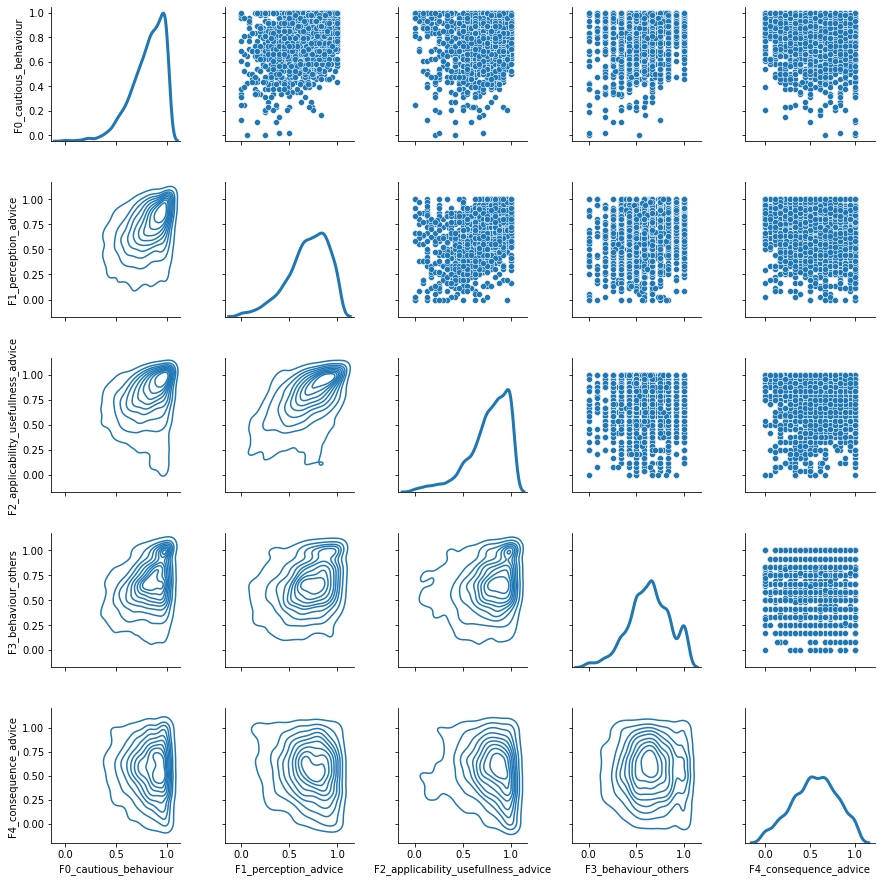

In [40]:
start = '2020-12-01'
end = '2020-12-14'
df_plot = df_fa_write.copy()
df_plot.date = pd.to_datetime(df_plot.date)
in_range = (df_plot.date > start) & (df_plot.date < end)
df_plot = df_plot[in_range]
df_plot = df_plot[factor_cols]
g = sns.PairGrid(data=df_plot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

In [41]:
import plotly.express as px
df_lineplot = df_fa_write[subset_drop].groupby('date').mean().reset_index()
df_lineplot[factor_cols] = df_lineplot[factor_cols].rolling(3).mean()
px.line(df_lineplot, x='date', y=factor_cols)

In [42]:
# convert to long (tidy) form
df_lineplot_long = df_lineplot.melt('date', var_name='factor', value_name='values')
df_lineplot_long = df_lineplot_long[df_lineplot_long['values'].notna()].reset_index(drop=True)
df_lineplot_long.date = pd.to_datetime(df_lineplot_long.date, format='%Y-%m-%d')
df_lineplot_long.head()

,date,factor,values
0,2020-08-03,F0_cautious_behaviour,0.745094
1,2020-08-04,F0_cautious_behaviour,0.751586
2,2020-08-05,F0_cautious_behaviour,0.755364
3,2020-08-06,F0_cautious_behaviour,0.767690
4,2020-08-07,F0_cautious_behaviour,0.774285


In [43]:
df_lineplot_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    910 non-null    datetime64[ns]
 1   factor  910 non-null    object        
 2   values  910 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 21.5+ KB


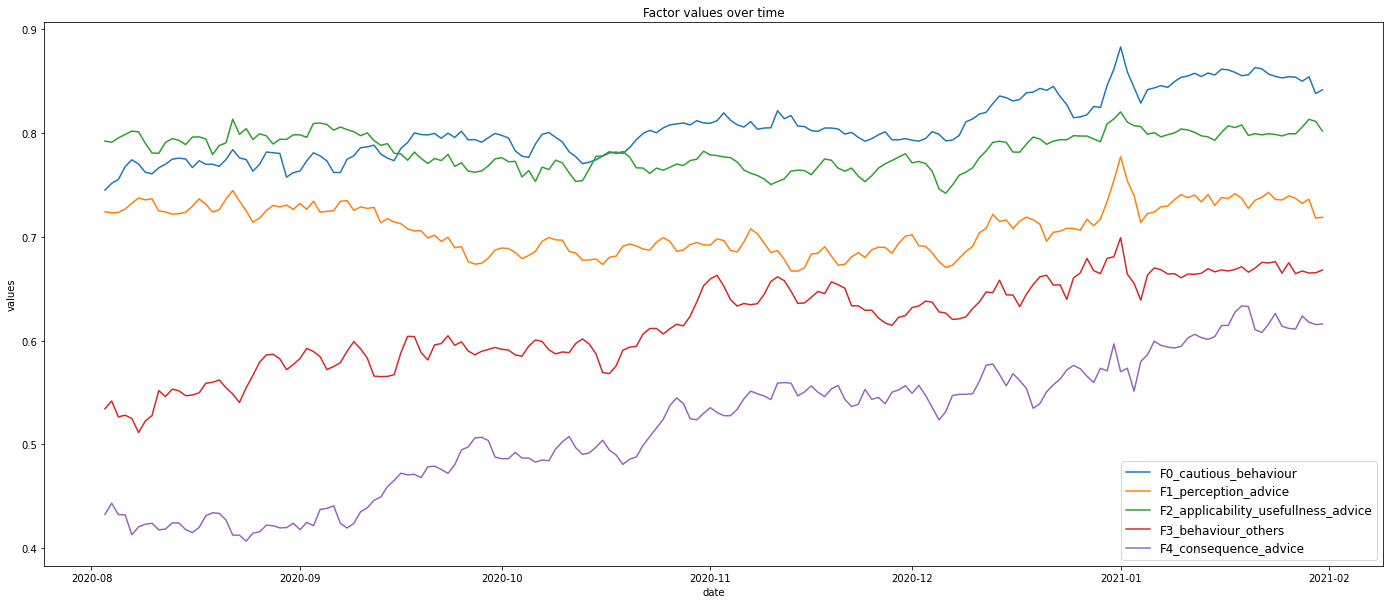

In [44]:
fig, ax = plt.subplots(figsize=(24, 10))
sns.lineplot(x="date", y="values", hue='factor', data=df_lineplot_long, ax=ax)
plt.title('Factor values over time')
ax.legend(loc='best', fontsize='large')
plt.show()

In [45]:
df_fa_write[subset_drop]

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice,date
2,0.875000,0.666667,0.291667,0.416667,0.611111,2020-11-06
3,0.708333,0.083333,0.041667,0.666667,0.111111,2020-12-09
4,1.000000,0.972222,0.750000,0.833333,0.611111,2020-10-21
5,0.958333,0.916667,0.958333,1.000000,0.500000,2020-08-08
6,0.916667,1.000000,1.000000,0.833333,0.222222,2020-09-04
...,...,...,...,...,...,...
114094,0.979167,0.888889,0.916667,0.500000,0.222222,2020-09-03
114096,1.000000,0.833333,0.916667,0.000000,0.833333,2020-11-09
114102,0.854167,0.611111,0.291667,0.585932,0.611111,2020-11-29
114104,0.520833,0.555556,0.708333,0.583333,0.500000,2020-12-05


In [46]:
cols = ['F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'date']
df_lineplot_sd = df_fa_write[cols].melt('date', var_name='factor', value_name='values')
df_lineplot_sd = df_lineplot_sd[df_lineplot_sd['values'].notna()].reset_index(drop=True)
df_lineplot_sd.date = pd.to_datetime(df_lineplot_sd.date, format='%Y-%m-%d')

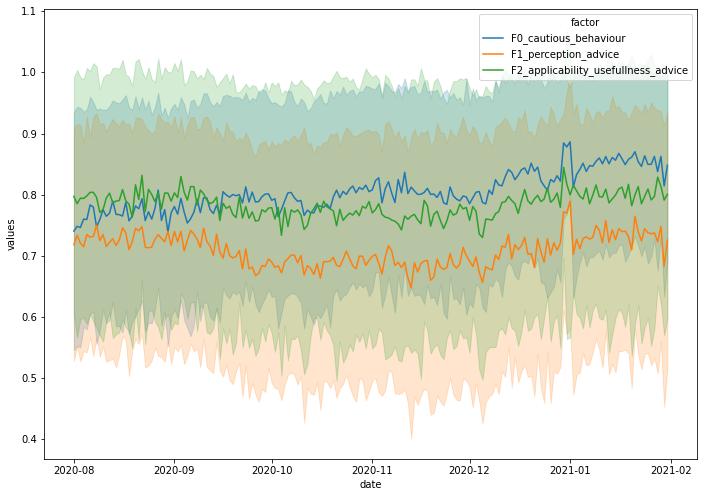

In [47]:
sns.lineplot(x="date", y="values", hue='factor', ci='sd', data=df_lineplot_sd)

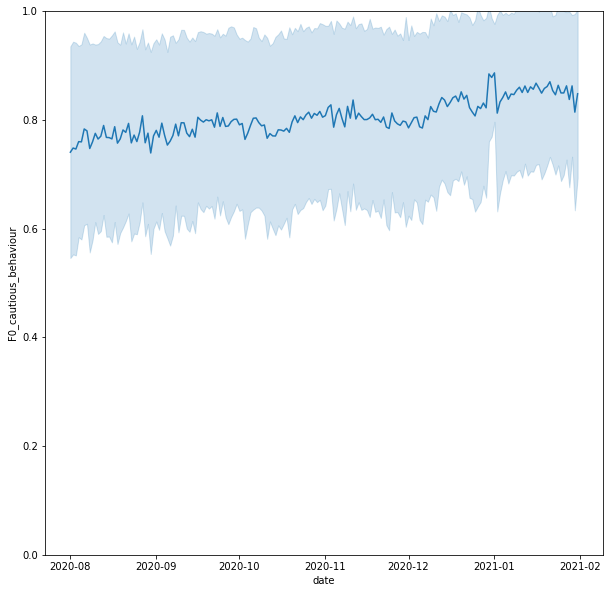

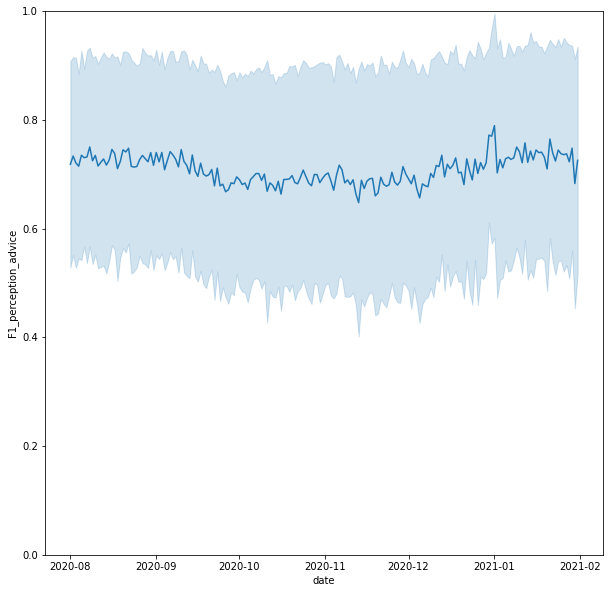

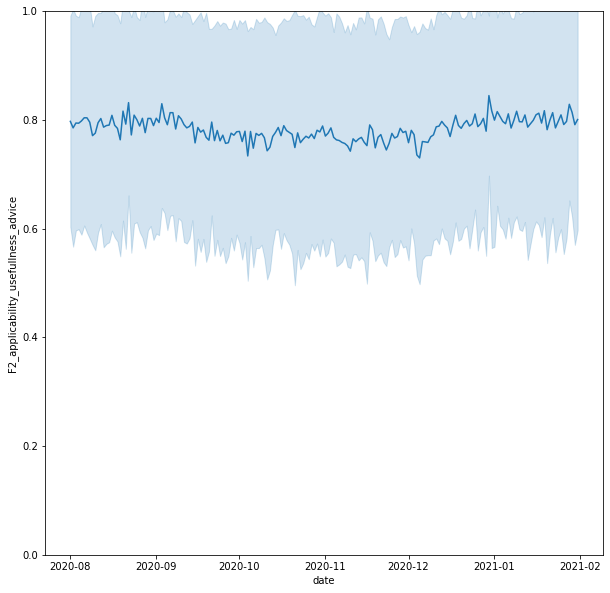

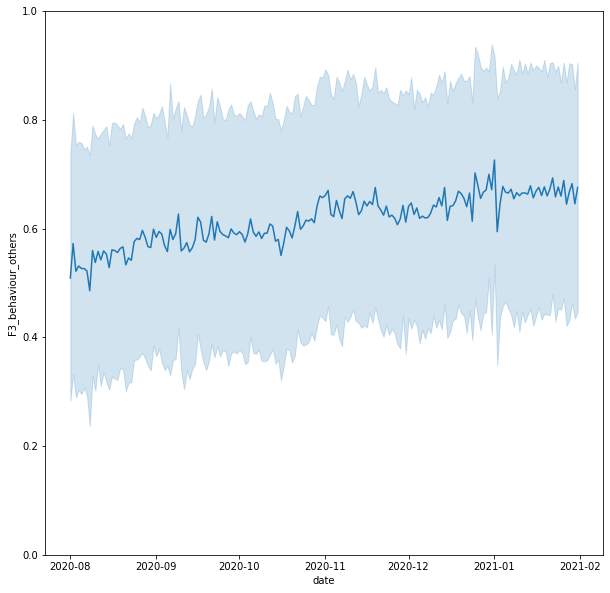

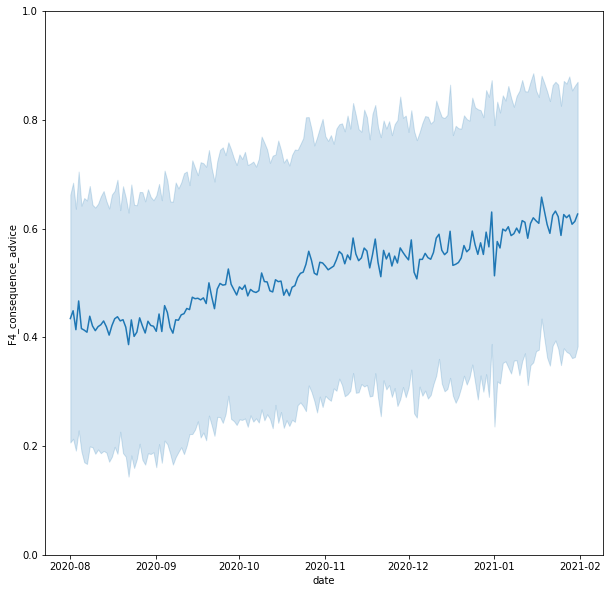

In [48]:
for col in factor_cols:
  fig, ax = plt.subplots(figsize=(10, 10))
  sns.lineplot(x="date", y=col, ci='sd', data=df_fa_write[subset_drop], ax=ax)
  ax.set_ylim([0, 1])
  fig.show()

# Write Data

In [49]:
df_fa_write_save.to_csv('data/preprocessing/dim_reduction/fa_data.csv', index=False)